In [1]:
import os
import sys
from glob import glob

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from sklearn.model_selection import StratifiedKFold

sys.path.append("../src/")
from utils.factory import read_yaml
from model import Model
from dataset import PetfinderDataModule
from pytorch_grad_cam.utils.image import show_cam_on_image

In [2]:
def reshape_transform(tensor, height=7, width=7):
    result = tensor.reshape(tensor.size(0), height, width, tensor.size(2))
    
    # like in CNNs
    result = result.permute(0, 3, 1, 2)
    return result

In [3]:
CONFIG_PATH = "../src/config/default.yaml"
config = read_yaml(CONFIG_PATH)

# 学習曲線のプロット

In [4]:
path = glob(f"../output/{config.General.name}/default/version_*/events*")

idx = 1
print(path[idx])
event_acc = EventAccumulator(path[idx], size_guidance={"scalars": 0})
event_acc.Reload()

scalars = {}
for tag in event_acc.Tags()["scalars"]:
    events = event_acc.Scalars(tag)
    scalars[tag] = [event.value for event in events]

../output/ex001/default/version_3/events.out.tfevents.1633600757.b3d8e2a13679.6250.0


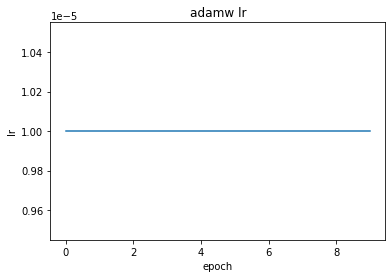

In [5]:
plt.plot(range(len(scalars["lr-AdamW"])), scalars["lr-AdamW"])
plt.xlabel("epoch")

plt.ylabel("lr")
plt.title("adamw lr")

plt.show()

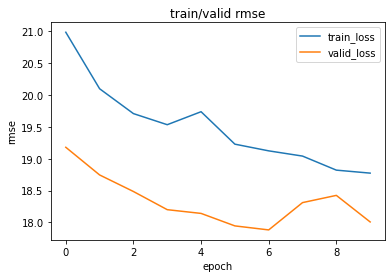

In [6]:
plt.plot(range(len(scalars["train_loss"])), scalars["train_loss"], label="train_loss")
plt.plot(range(len(scalars["valid_loss"])), scalars["valid_loss"], label="valid_loss")
plt.legend()
plt.xlabel("epoch")

plt.ylabel("rmse")
plt.title("train/valid rmse")

plt.show()

In [7]:
print('best val score', min(scalars['valid_loss']))

best val score 17.882156372070312


# grad cam

In [7]:
# df読み込む
df = pd.read_csv(os.path.join('../input', 'train.csv'))
df['Id'] = df['Id'].apply(lambda x: os.path.join('../input/train', x+'.jpg'))


skf = StratifiedKFold(
    n_splits=config.dataset.kfold, shuffle=True, random_state=config.General.seed
)

for fold, (train_idx, val_idx) in enumerate(skf.split(df["Id"], df["Pawpularity"])):
    train_df = df.loc[train_idx].reset_index(drop=True)

    val_df = df.loc[val_idx].reset_index(drop=True)
    break

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [8]:
model = Model(config)
model.load_state_dict(torch.load(f"../output/{config.General.name}/best_loss-v3.ckpt")["state_dict"])
model = model.cpu().eval()

datamodule = PetfinderDataModule(train_df, val_df, config)
images, grayscale_cams, preds, labels = model.check_gradcam(
    datamodule.val_dataloader(), target_layer=model.backbone.layers[-1].blocks[-1].norm1, target_category=None, 
    reshape_transform=reshape_transform
)

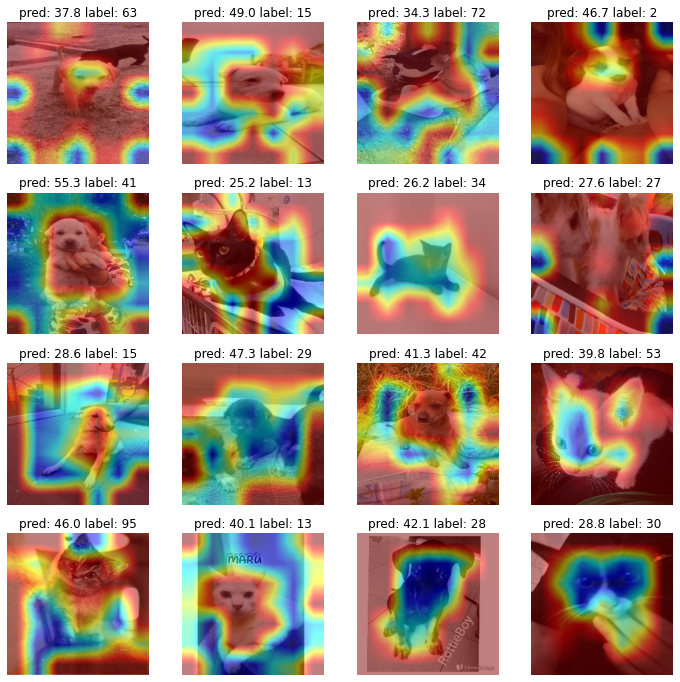

In [12]:
plt.figure(figsize=(12, 12))
for it, (image, grayscale_cam, pred, label) in enumerate(zip(images, grayscale_cams, preds, labels)):
    plt.subplot(4, 4, it + 1)
    visualization = show_cam_on_image(image, grayscale_cam)
    plt.imshow(visualization)
    plt.title(f'pred: {pred:.1f} label: {label}')
    plt.axis('off')